## **We analyse the binned glacier area on each tile.**

### Take the tile-30-95 as example.


In [1]:
import matplotlib.pyplot as plt
from utils.geotif_io import readTiff
from utils.transform_xy import geo2imagexy
from utils.crop_to_extent import crop_to_extent
import numpy as np
import h5py


In [1]:
### Tile number determination
extent_bottom, extent_left = 30, 95
year = '2019'
data_type = 'GLAH14' if year in ['2006', '2007', '2008', '2009'] else 'ATL06'
year_lc30 = '2010' if year in ['2006', '2007', '2008', '2009'] else '2020'
print('Icesat data type:', data_type)
print('Globeland30 year:', year_lc30)



Icesat data type: ATL06
Globeland30 year: 2020


### Dem data.

In [35]:
path_srtm = 'data/dem-data/srtm-c/tiles/tile_'+str(extent_bottom)+'_'+str(extent_left)+'.tif'
path_srtm_albers = 'data/dem-data/srtm-c/tiles/tile_'+str(extent_bottom)+'_'+str(extent_left)+'_albers.tif'  ## used for area calculation.
srtm, srtm_info = readTiff(path_srtm)
srtm_albers, srtm_albers_info = readTiff(path_srtm_albers)
srtm[srtm<0]=0; srtm_albers[srtm_albers<0]=0
print(srtm.shape, srtm_albers.shape)


(3600, 3600) (4028, 3502)


### Glacier mask

In [36]:
path_glacier = 'data/rgi60/tiles/tile_'+str(extent_bottom)+'_'+str(extent_left)+'.tif'
path_glacier_albers = 'data/rgi60/tiles/tile_'+str(extent_bottom)+'_'+str(extent_left)+'_albers.tif'
mask_glacier = crop_to_extent(path_img=path_glacier, extent=srtm_info['geoextent'], size_target=srtm.shape) # read and resize
mask_glacier_albers = crop_to_extent(path_img=path_glacier_albers, \
                                extent=srtm_albers_info['geoextent'], size_target=srtm_albers.shape) # read and resize
mask_glacier[mask_glacier<0]=0; mask_glacier = np.int8(mask_glacier)
mask_glacier_albers[mask_glacier_albers<0]=0; mask_glacier_albers = np.int8(mask_glacier_albers)
print(mask_glacier.shape, mask_glacier_albers.shape)


(3600, 3600) (4028, 3502)


### Statistic of the glacier area of each 100-m elevation bin (based on the albers projection). 

In [37]:
### Statistic of the glacier area of each 100-m elevation bin.
glacier_area_bins = {}
glacier_area = 0
srtm_glacier = srtm_albers*mask_glacier_albers
srtm_glacier_ = srtm_glacier[srtm_glacier>0]
h_start, h_end = np.nanmin(srtm_glacier_), np.nanmax(srtm_glacier_)
bin_start, bin_end = np.floor(h_start/100)*100, np.ceil(h_end/100)*100
print("bin_start, bin_end: ",bin_start, bin_end)
num_bin = ((bin_end - bin_start)/100).astype(int)
for i in range(num_bin):
  start, end = bin_start + i*100,  bin_start + i*100 + 100
  ids_pixels_bin = np.where((srtm_glacier > start) & (srtm_glacier < end))[0]
  area_pixels_bin = ids_pixels_bin.shape[0]*0.03*0.03   ### the height and width of pixel is 0.03 km
  glacier_area_bins[str(start.astype(int))+'-'+str(end.astype(int))] = area_pixels_bin
  glacier_area += area_pixels_bin
print('overall glacier area (km2):', glacier_area)
print(glacier_area_bins.keys())


bin_start, bin_end:  3200.0 6300.0
overall glacier area (km2): 670.4298
dict_keys(['3200-3300', '3300-3400', '3400-3500', '3500-3600', '3600-3700', '3700-3800', '3800-3900', '3900-4000', '4000-4100', '4100-4200', '4200-4300', '4300-4400', '4400-4500', '4500-4600', '4600-4700', '4700-4800', '4800-4900', '4900-5000', '5000-5100', '5100-5200', '5200-5300', '5300-5400', '5400-5500', '5500-5600', '5600-5700', '5700-5800', '5800-5900', '5900-6000', '6000-6100', '6100-6200', '6200-6300'])


([<matplotlib.axis.XTick at 0x7fc143fc26a0>,
 [Text(1.0, 0, '3200.0'), Text(15.5, 0, '4750.0'), Text(31.0, 0, '6300.0')])

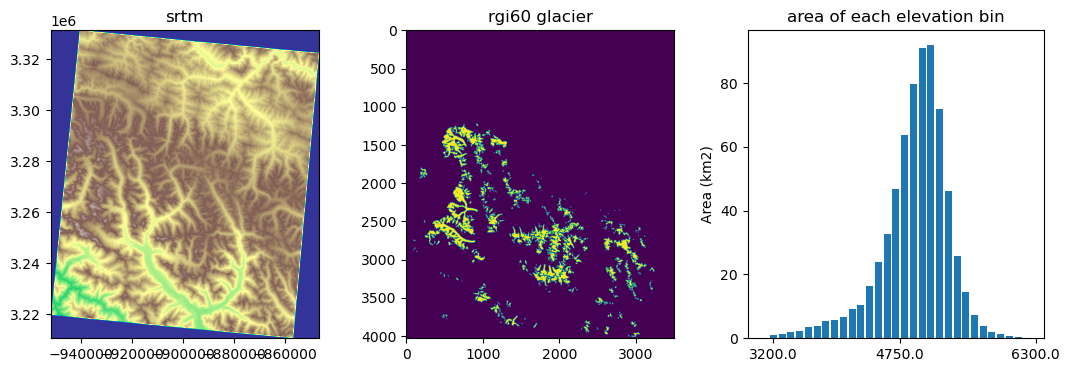

In [38]:
plt.figure(figsize=(13,4))
plt.subplot(1,3,1)
plt.imshow(srtm_albers, vmin=0, vmax=7000, extent=srtm_albers_info['geoextent'], cmap='terrain')
plt.title('srtm')
plt.subplot(1,3,2)
plt.imshow(mask_glacier_albers)
plt.title('rgi60 glacier')
plt.subplot(1,3,3)
num_bins = len(glacier_area_bins.keys())
plt.bar(range(len(glacier_area_bins.keys())), glacier_area_bins.values())
plt.title("glacier area of each elevation bin")
plt.ylabel("Area (km2)")
plt.xticks([1, num_bins/2, num_bins], [str(bin_start), str((bin_end+bin_start)/2), str(bin_end)])
